In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.describe(include='all')

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000,64000.000000,64000,64000,64000.000000
unique,NaN,NaN,NaN,NaN,3,NaN,3,3,NaN
top,NaN,NaN,NaN,NaN,Surburban,NaN,Web,Buy One Get One,NaN
freq,NaN,NaN,NaN,NaN,28776,NaN,28217,21387,NaN
mean,5.763734,242.085656,0.551031,0.549719,NaN,0.502250,NaN,NaN,0.146781
std,3.507592,256.158608,0.497393,0.497526,NaN,0.499999,NaN,NaN,0.353890
min,1.000000,29.990000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
25%,2.000000,64.660000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
50%,6.000000,158.110000,1.000000,1.000000,NaN,1.000000,NaN,NaN,0.000000
75%,9.000000,325.657500,1.000000,1.000000,NaN,1.000000,NaN,NaN,0.000000


In [4]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

In [5]:
df.rename(columns={'conversion': 'target', 'offer' : 'treatment'}, inplace=True)

In [6]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [7]:
df.treatment.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [8]:
df['treatment'].where(df['treatment'] == 'No Offer', 1, inplace=True)
df['treatment'].replace('No Offer', 0, inplace=True)

In [9]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [10]:
df.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

Пока не до энжинеринга.

In [11]:
indices_learn, indices_valid  = train_test_split(df.index,  random_state=25)

In [12]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [13]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [14]:
X_train = df.loc[indices_learn, :].drop(labels=['treatment', 'target'] ,axis=1)
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(labels=['treatment', 'target'] ,axis=1)
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

X_train_full = df.drop(labels=['treatment', 'target'] ,axis=1)
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']


cat_features = ['zip_code', 'channel', 'used_discount', 'used_bogo', 'is_referral']

models_results = []


Будет время, подумаю делать ли feature enginering.

# S-learn

In [15]:
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=20):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    # check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

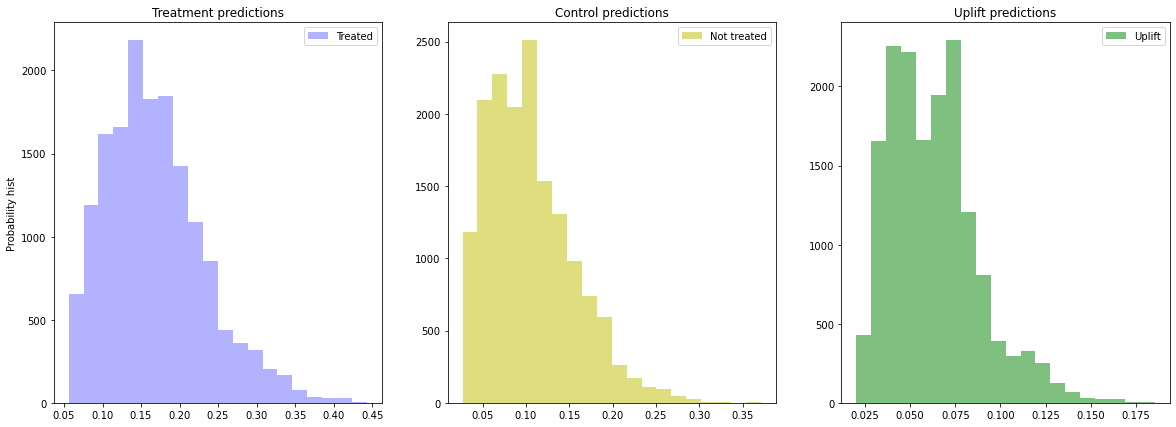

In [16]:

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)
for k in (0.1, 0.2):
    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=k)


    models_results.append(['S-learn', k , sm_score])
    # models_results['approach'].append(f'S-learn: uplift@{k *100}%')
    # models_results['uplift'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [17]:
models_results

[['S-learn', 0.1, 0.04540446962543279], ['S-learn', 0.2, 0.05459248772132205]]

Какойто сомнителный результат, у 10% топа uplift меньше - странно. может что то с процессом обучения, нeдообучения.

In [18]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

for k in (0.1, 0.2):
    ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=k)
    models_results.append(['ClassTransformation', k , ct_score])
    # models_results['approach'].append(f'ClassTransformation: uplift@{k *100}%')
    # models_results['uplift'].append(sm_score)

In [19]:
models_results

[['S-learn', 0.1, 0.04540446962543279],
 ['S-learn', 0.2, 0.05459248772132205],
 ['ClassTransformation', 0.1, 0.06701290525653131],
 ['ClassTransformation', 0.2, 0.05426389107370702]]

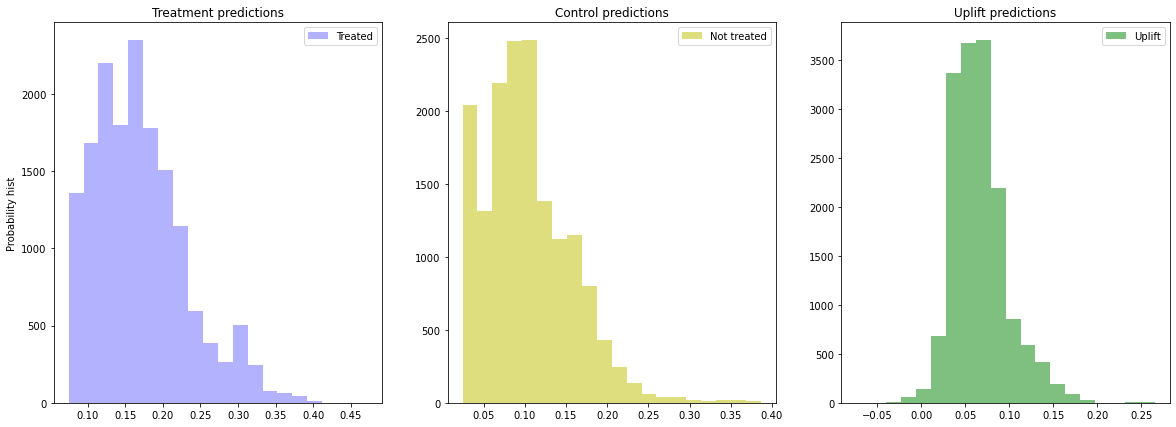

In [20]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)
for k in (0.1, 0.2):
    tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=k)
    models_results.append(['TwoModels', k , tm_score])
# models_results['approach'].append('TwoModels')
# models_results['uplift'].append(tm_score)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [21]:
models_results = np.array(models_results)
models_results

array([['S-learn', '0.1', '0.04540446962543279'],
       ['S-learn', '0.2', '0.05459248772132205'],
       ['ClassTransformation', '0.1', '0.06701290525653131'],
       ['ClassTransformation', '0.2', '0.05426389107370702'],
       ['TwoModels', '0.1', '0.06486727520721855'],
       ['TwoModels', '0.2', '0.06292582105465541']], dtype='<U19')

In [22]:
results = models_results[:,2]
df_results = pd.DataFrame(results.reshape(3,2), index=['S-learn', 'ClassTransformation', 'TwoModels'], columns=['uplift10%', 'uplift@20%'])
df_results

,uplift10%,uplift@20%
S-learn,0.04540446962543279,0.05459248772132205
ClassTransformation,0.06701290525653131,0.05426389107370702
TwoModels,0.06486727520721855,0.06292582105465541


Выводы сдалать сложно так как S-learn показал крайне странные результаты. Скорее всего, без тюнинга параметров catboost, будет неправильно сравнивать реультаты.

# Дерево

In [23]:
X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel', dtype='int32')], 1)
X_train_tree = pd.concat([X_train_tree.drop('zip_code', 1), 
                          pd.get_dummies(X_train_tree['zip_code'], prefix='zip_code', dtype='int32')], 1)
features = [col for col in X_train_tree]

In [24]:
X_train_tree.dtypes


recency                   int64
history                 float64
used_discount             int64
used_bogo                 int64
is_referral               int64
channel_Multichannel      int32
channel_Phone             int32
channel_Web               int32
zip_code_Rural            int32
zip_code_Surburban        int32
zip_code_Urban            int32
dtype: object

In [25]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


Wall time: 4 s


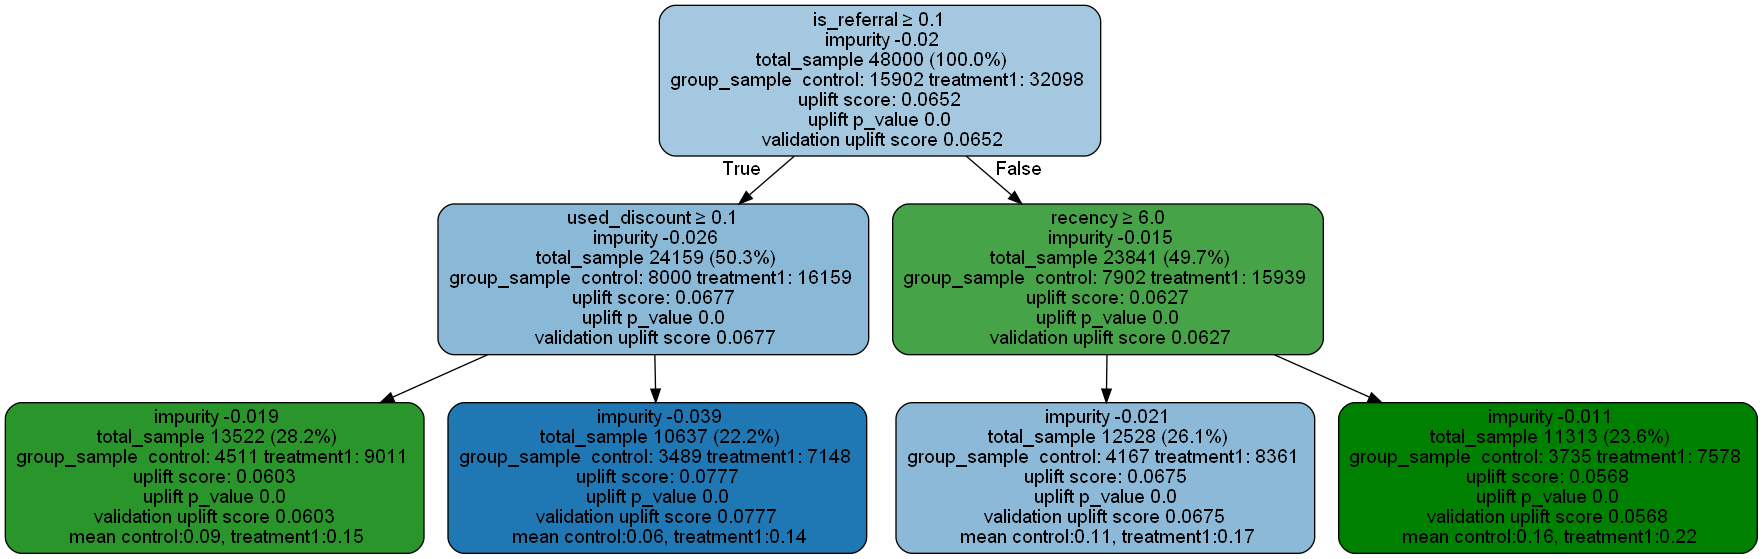

In [26]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Вполне приличное деерво,  uplift p_value везеде нули, так что мы имеем значимый uplift.

Получилось 2 типа нам интресных людей:
- пришедшие по реферальной ссылке и получавшие уже скидку.
- пришедших не по рефералке но далавшие последнюю покупку больше 6 месяцев назад

# Лес

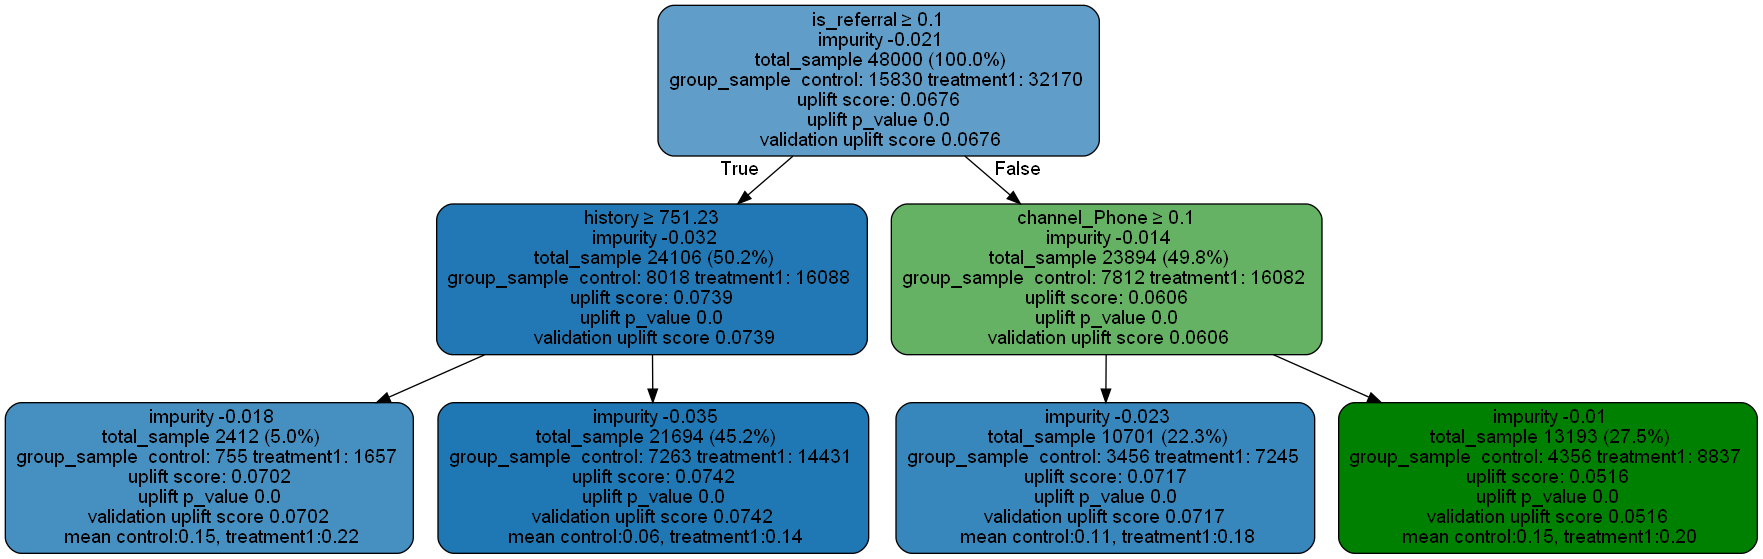

In [27]:
uplift_model = UpliftRandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)
uplift_tree = uplift_model.uplift_forest[3]

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features)
Image(graph.create_png())

Тут мы можем смотреть только результаты отдельного дерева в ансамбле. Эти имеет мало смысла, так как сильно перекошенна выборка из-за того, что некоторые люди тут повторяются несколько раз. В данном случае лучше смотреть на feature_impotance.